# Data Cleaning

Even though we now have all our extracted data, there are still null values and string and object format columns. Because of that, we had to clean our data.

We start by importing relevant libraries and the dataframes we obtained in the feature extraction step.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df_pyradiomics = pd.read_csv('pyradiomics_extraction_fixed.csv', index_col=False)
df_pylidc = pd.read_csv('pylidc_features_fixed.csv', index_col=False)

C:\Users\anton\AppData\Local\Temp\ipykernel_2600\3687287947.py:1: DtypeWarning: Columns (38,39,40,41,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df_pyradiomics = pd.read_csv('pyradiomics_extraction_fixed.csv', index_col=False)


### Binary Classification

Before merging both dataframes, we decided to tackle this problem using a binary target, malign and benign.

#### Default distribution

We start by looking at how our target's distribution by the different labels.

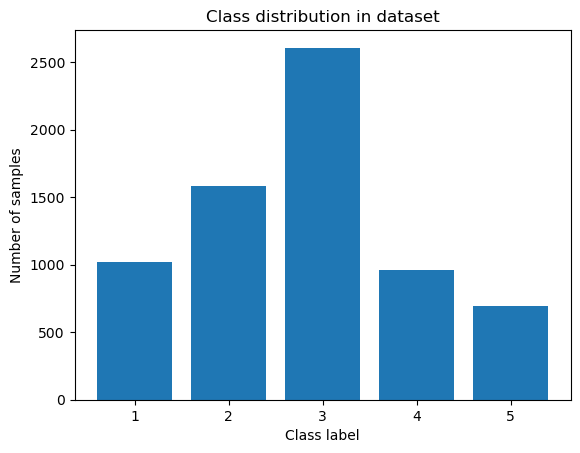

[1 2 3 4 5] [1020 1580 2606  962  691]


In [5]:
unique_labels, counts = np.unique(df_pylidc.malignancy, return_counts=True)
plt.bar(unique_labels, counts)
plt.xlabel('Class label')
plt.ylabel('Number of samples')
plt.title('Class distribution in dataset')
plt.show()

print(unique_labels, counts)

The first step for turning our target binary is merging similar classes:

- -1  -> 'Highly Unlikely'(1) and 'Moderately Unlikely'(2)
- 0  -> 'Indeterminate'(3)
- 1  -> 'Moderately Suspicious'(4) and 'Highly Suspicious'(5)

In [6]:
for i in range(len(df_pylidc)):
    if df_pylidc.at[i,'malignancy'] == 1 or df_pylidc.at[i,'malignancy'] == 2:
        df_pylidc.at[i,'malignancy'] = -1
    elif df_pylidc.at[i,'malignancy'] == 4 or df_pylidc.at[i,'malignancy'] == 5:
        df_pylidc.at[i,'malignancy'] = 1
    else:
        df_pylidc.at[i,'malignancy'] = 0

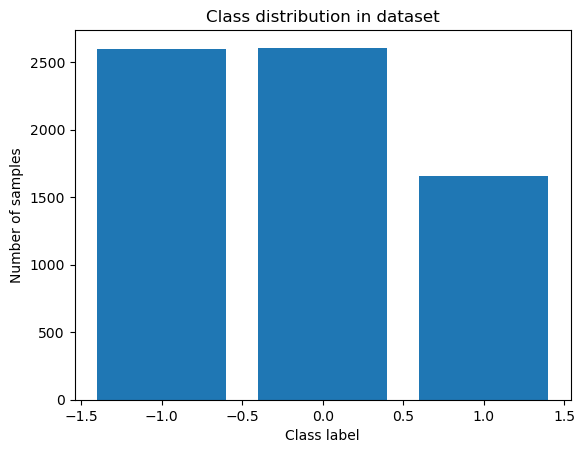

[-1  0  1] [2600 2606 1653]


In [7]:
unique_labels, counts = np.unique(df_pylidc.malignancy, return_counts=True)
plt.bar(unique_labels, counts)
plt.xlabel('Class label')
plt.ylabel('Number of samples')
plt.title('Class distribution in dataset')
plt.show()

print(unique_labels, counts)

Next, we transform '0' labeled examples into the most common class within each patient. For that we start by defining a function that returns the most common class.

In [8]:
def most_common_class(group):
    mode_class = group['malignancy'].mode()
    if not mode_class.empty:
        return mode_class.iloc[0]
    else:
        return 0

Then, we create a dictionary to store the most common class for each patient and change our dataframe.

In [9]:
most_common_per_patient = df_pylidc.groupby('patient_id').apply(most_common_class).to_dict()

df_pylidc['malignancy'] = df_pylidc.apply(lambda row: most_common_per_patient.get(row['patient_id'], row['malignancy']) if row['malignancy'] == 0 else row['malignancy'], axis=1)

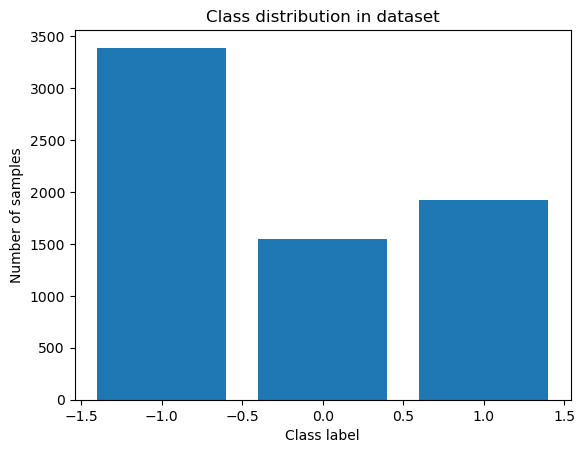

[-1  0  1] [3388 1549 1922]


In [10]:
unique_labels, counts = np.unique(df_pylidc.malignancy, return_counts=True)
plt.bar(unique_labels, counts)
plt.xlabel('Class label')
plt.ylabel('Number of samples')
plt.title('Class distribution in dataset')
plt.show()

print(unique_labels, counts)

Finally, we remove the remaining patients with target '0' as majority. For that, we group the dataframe by 'patient_id', count the ocurrences of each diagnosis and identify the ones we want to remove.

In [11]:
diagnosis_counts = df_pylidc.groupby('patient_id')['malignancy'].value_counts().unstack(fill_value=0)

majority_0_patients = diagnosis_counts.idxmax(axis=1) == 0

df_pylidc = df_pylidc[~df_pylidc['patient_id'].isin(majority_0_patients[majority_0_patients].index)]

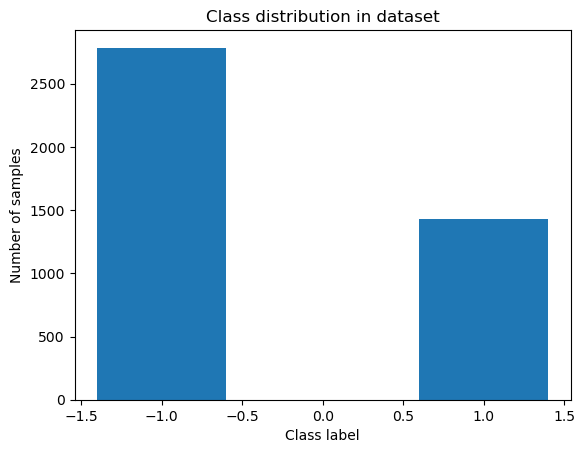

[-1  1] [2785 1433]


In [12]:
unique_labels, counts = np.unique(df_pylidc.malignancy, return_counts=True)
plt.bar(unique_labels, counts)
plt.xlabel('Class label')
plt.ylabel('Number of samples')
plt.title('Class distribution in dataset')
plt.show()

print(unique_labels, counts)

In [13]:
df_pylidc.to_csv('final_pylidc_extraction.csv', sep=',', index=False)

### Features Merge

The next step, after having the target in the format we wanted, is to merge both datasets.

In [14]:
print(df_pylidc.shape)
print(df_pyradiomics.shape)

(4218, 16)
(4696, 1599)


In [15]:
df = df_pyradiomics.merge(df_pylidc, left_on='id', right_on='Id')
df = df.drop(columns=['Id'])
df.shape

(2948, 1614)

### Columns removal

#### Null Values and Constants

We removed all the columns that are constants in the dataframe or that contained null values.

In [16]:
removed = 0
for col in df.columns:
    if len(df[col].unique()) == 1:
        df = df.drop(columns=col)
        removed += 1

for col in df.columns:
    null_count = df[col].isnull().sum()
    if null_count > 0:
        df = df.drop(columns=col)
        removed += 1

We were left with the following columns.

In [17]:
print(df.shape)
print(f"Total number of columns deleted: {removed}")

(2948, 1314)
Total number of columns deleted: 300


We took then a look at the number of individual patients in the training set and the resulting distribution of the target class.

In [18]:
len(df['patient_id'].unique())

435

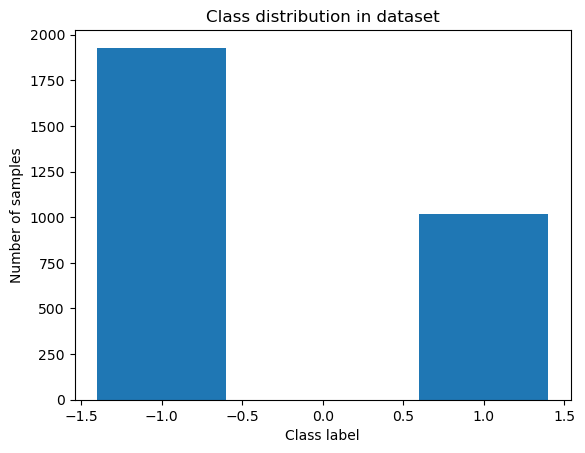

[-1  1] [1929 1019]


In [19]:
unique_labels, counts = np.unique(df.malignancy, return_counts=True)
plt.bar(unique_labels, counts)
plt.xlabel('Class label')
plt.ylabel('Number of samples')
plt.title('Class distribution in dataset')
plt.show()

print(unique_labels, counts)

#### String and Object Types

We need to be careful when working with string and object types, so we start by finding out how many we had, and which they were.

In [20]:
df.dtypes.value_counts()

float64    1281
object       20
int64        13
dtype: int64

In [21]:
df_groupby_dtypes = df.columns.to_series().groupby(df.dtypes).groups

for key, value in df_groupby_dtypes.items():
    if key == 'object':
        print(value)

Index(['id', 'diagnostics_Mask-original_Hash',
       'diagnostics_Mask-original_Spacing', 'diagnostics_Mask-original_Size',
       'diagnostics_Mask-original_BoundingBox',
       'diagnostics_Mask-original_CenterOfMassIndex',
       'diagnostics_Mask-original_CenterOfMass',
       'diagnostics_Image-interpolated_Spacing',
       'diagnostics_Image-interpolated_Size',
       'diagnostics_Mask-interpolated_Spacing',
       'diagnostics_Mask-interpolated_Size',
       'diagnostics_Mask-interpolated_BoundingBox',
       'diagnostics_Mask-interpolated_CenterOfMassIndex',
       'diagnostics_Mask-interpolated_CenterOfMass',
       'original_shape_Elongation', 'original_shape_Flatness',
       'original_shape_LeastAxisLength', 'original_shape_MajorAxisLength',
       'original_shape_MinorAxisLength', 'patient_id'],
      dtype='object')


We then gathered the object columns (except for ids) and removed them.

Some contained coordinate tuples, which we below converted into new columns.

In [22]:
object_columns = [
    'diagnostics_Mask-original_Spacing',
    'diagnostics_Mask-original_Size',
    'diagnostics_Mask-original_BoundingBox',
    'diagnostics_Mask-original_CenterOfMassIndex',
    'diagnostics_Mask-original_CenterOfMass',
    'diagnostics_Image-interpolated_Spacing',
    'diagnostics_Image-interpolated_Size',
    'diagnostics_Mask-interpolated_Spacing',
    'diagnostics_Mask-interpolated_Size',
    'diagnostics_Mask-interpolated_BoundingBox',
    'diagnostics_Mask-interpolated_CenterOfMassIndex',
    'diagnostics_Mask-interpolated_CenterOfMass',
    'diagnostics_Mask-original_Hash',
    'original_shape_Elongation', 
    'original_shape_Flatness',
    'original_shape_LeastAxisLength', 
    'original_shape_MajorAxisLength',
    'original_shape_MinorAxisLength',
    ]

object = df[object_columns]
df = df.drop(columns = object_columns)

To treat string type columns '(x, y, z)' we iterated and separated them into separate columns x, y and z.

In [23]:
for j in range(0, 12):
    col = object[object_columns[j]]
    comma_count = col.iloc[0].count(',')

    # define new column names 
    list = []
    for i in range(comma_count + 1):
        name = object_columns[j] + "_" + str(i)
        list.append(name)

    for k in range(len(object)):
        s = col.iloc[k]

        # split the column into separate columns
        s = s.strip('()')
        values = [float(idx) for idx in s.split(', ')]
        
        for k1 in range(len(list)):
            object[list[k1]] = values[k1]

    object = object.drop(columns= object_columns[j])

Then we dropped the remaining columns with questionable data, such as hash values or imaginary values, for example.

In [24]:
object = object.drop(columns= object.columns[0:6])
object.head()

,diagnostics_Mask-original_Spacing_0,diagnostics_Mask-original_Spacing_1,diagnostics_Mask-original_Spacing_2,diagnostics_Mask-original_Size_0,diagnostics_Mask-original_Size_1,diagnostics_Mask-original_Size_2,diagnostics_Mask-original_BoundingBox_0,diagnostics_Mask-original_BoundingBox_1,diagnostics_Mask-original_BoundingBox_2,diagnostics_Mask-original_BoundingBox_3,...,diagnostics_Mask-interpolated_BoundingBox_2,diagnostics_Mask-interpolated_BoundingBox_3,diagnostics_Mask-interpolated_BoundingBox_4,diagnostics_Mask-interpolated_BoundingBox_5,diagnostics_Mask-interpolated_CenterOfMassIndex_0,diagnostics_Mask-interpolated_CenterOfMassIndex_1,diagnostics_Mask-interpolated_CenterOfMassIndex_2,diagnostics_Mask-interpolated_CenterOfMass_0,diagnostics_Mask-interpolated_CenterOfMass_1,diagnostics_Mask-interpolated_CenterOfMass_2
0,0.859375,0.859375,2.5,512.0,512.0,8.0,390.0,284.0,0.0,32.0,...,0.0,13.0,11.0,10.0,17.041265,16.108666,4.184319,128.652843,34.787644,-229.881362
1,0.859375,0.859375,2.5,512.0,512.0,8.0,390.0,284.0,0.0,32.0,...,0.0,13.0,11.0,10.0,17.041265,16.108666,4.184319,128.652843,34.787644,-229.881362
2,0.859375,0.859375,2.5,512.0,512.0,8.0,390.0,284.0,0.0,32.0,...,0.0,13.0,11.0,10.0,17.041265,16.108666,4.184319,128.652843,34.787644,-229.881362
3,0.859375,0.859375,2.5,512.0,512.0,8.0,390.0,284.0,0.0,32.0,...,0.0,13.0,11.0,10.0,17.041265,16.108666,4.184319,128.652843,34.787644,-229.881362
4,0.859375,0.859375,2.5,512.0,512.0,8.0,390.0,284.0,0.0,32.0,...,0.0,13.0,11.0,10.0,17.041265,16.108666,4.184319,128.652843,34.787644,-229.881362


When merging the new columns with the dataframe, we can see we no longer have object types asides from 'id' and 'patient_id'.

In [25]:
df = pd.concat([df, object], axis=1)
print(df.dtypes.value_counts())
print(df.shape)

float64    1323
int64        13
object        2
dtype: int64
(2948, 1338)


#### Low Correlation

We checked the correlation of our features with the target and decided to removed the ones with correlation lower than 0.05.

In [26]:
index = df[['id', 'patient_id']]
features = df.drop(columns=['id', 'patient_id'])

In [27]:
correlations_with_target = features.corr()['malignancy']
features_to_remove = correlations_with_target[abs(correlations_with_target) < 0.05].index
df_filtered = features.drop(columns=features_to_remove)

df_filtered.shape

(2948, 1131)

In [28]:
df = pd.concat([index, df_filtered], axis=1) 
df.shape

(2948, 1133)

We saved our final CSV file, which will be used for model training and testing.

In [29]:
df.to_csv('data.csv', sep=',', index=False)